+++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Naturally, this is work in progress and many things here change
as I learn new methods and models and other stuff

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Titanic @ Kaggle

## 1. Overall
This is a classification problem: based on some input parameters, we need to predict one of the two binary outcomes - 0 (passenger dies) and 1 (passenger survives).
Let's take a look at our data first:

In [1]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print("TRAIN DATAFRAME SHAPE =",train_df.shape)
train_df.head()

TRAIN DATAFRAME SHAPE = (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have several features and 2 problems which we already can see:
1. Not all the features appear to be meaningful
2. Some observations have NaN values

## 2. Features
What features can be removed without affecting predictions too much (or at all)?
- **PassengerID**: that's basically rowID, nothing more. Seems OK to drop it.
- **Survived**: that's vector with 2 response classes, 0 and 1. Will go to *y*.
- **Pclass**: this seems meaningful (rich guys are more likely to survive?)
- **Name**: this feature does not look very useful. Every passenger has a different Name value (repeated Names are extremely rare), and it seems very unlikely for the name to influence survival. For now we will drop it.
- **Sex**: this seems meaningful (women are more likely to survive?).
- **Age**: this seems meaningful (children are more likely to survive?)
- **SibSp**: unknown for now
- **Parch**: unknown for now
- **Ticket**: unknown for now
- **Fare**: useful? (rich guys are more likely to survive?)
- **Cabin**: cabin may be a meaningful feature, for example upper cabins might be closer to life boats and thus passengers in those cabins may might have a greater chance of survival, but for now it's not clear what to do with it, as it has too much NaN values:

In [2]:
train_df['Cabin'].isnull().sum()

687

- **Cabin**: so Cabin feature has 687 NaNs out of 891 values in total, which means that NaNs are dominating. Question here: what should we do? Should we drop Cabin feature altogether, or should we substitute NaNs with some random values? That however is difficult as missing data in Cabins seems to be of MCAR type - Missing Completely At Random (indeed, we do not have a straightforward cabin numbers list like "1, 2, 3, 4, x, 6, 7" from which we could deduce that x=5; instead Cabin numbers are listed randomly so it would be difficult to predict the expected value in NaN cells)
- **Embarked**: unknown for now. Substitute string values with some labels, say C=0, Q=1, S=2

So for now let's drop PassengerID and Name features and change string values to labels and see what we've got:

In [3]:
train_df.drop(['Name', 'PassengerId'], 1, inplace=1)
test_df.drop(['Name','PassengerId'], 1, inplace=1)
mapping = {'male': 0, 'female': 1, 'C': 0, 'Q': 1, 'S': 2}
train_df = train_df.replace({'Sex': mapping, 'Embarked': mapping})
test_df = test_df.replace({'Sex': mapping, 'Embarked': mapping})
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,1,1,1,38.0,1,0,PC 17599,71.2833,C85,0.0
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,1,1,1,35.0,1,0,113803,53.1000,C123,2.0
4,0,3,0,35.0,0,0,373450,8.0500,NaN,2.0


### Pclass
How did ticket class affect chances of survival?

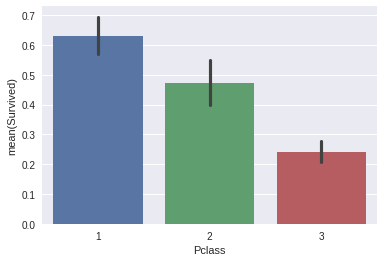

In [29]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x="Pclass", y="Survived", data=train_df)
plt.show()

So, indeed, the tendency is clear: *the higher the class -> the greater chance of survival*.

### Sex

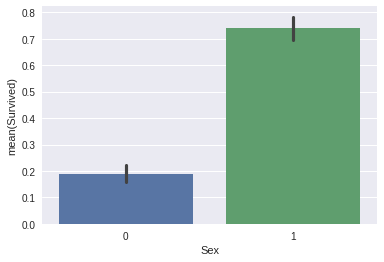

In [30]:
sns.barplot(x="Sex", y="Survived", data=train_df)
plt.show()

Again as expected: *females were more likely to survive*.

### Age
Let's check the Age now:

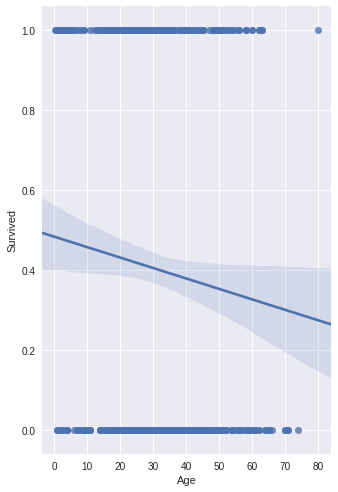

In [31]:
sns.pairplot(train_df, x_vars=['Age'], y_vars='Survived', size=7, aspect=0.7, kind='reg')
plt.show()

It seems like greater age provided less chance of survival? - but the variance here is not that small so it may be not that reliable, I don't know yet.

### SibSp
What about siblings and spouces?

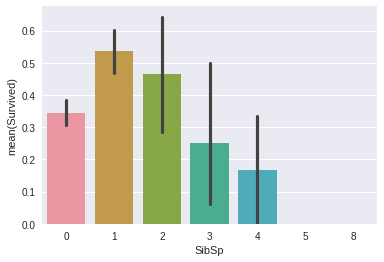

In [33]:
sns.barplot(x="SibSp", y="Survived", data=train_df)
plt.show()

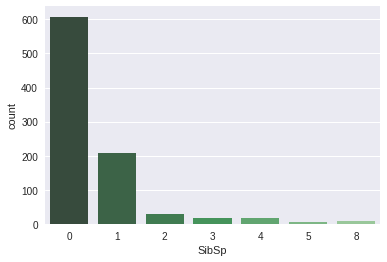

In [34]:
sns.countplot(x="SibSp", data=train_df, palette="Greens_d")
plt.show()

That does not tell us all that much.

### Parch

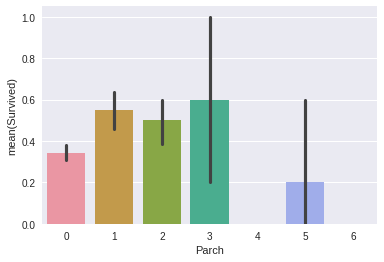

In [35]:
sns.barplot(x="Parch", y="Survived", data=train_df)
plt.show()

Again, I don't really know how to interpret that yet.. Does not seem to be a clear tendency to survival (or dying) here.

### Ticket
That thing is kind of hard to plot, because there are some 700-800+ distinct values. Should I go for pairplot?

**Maybe here we need to do some kind of feature engineering** to break tickets into several various classes? Actually we see that most of the tickets seem to have a 1, 2 or 3 in the beggining of their numerical part. Could that mean Pclass? Let's see:

In [54]:
print(train_df[['Pclass', 'Ticket']].head())
train_df[['Pclass', 'Ticket']].tail()
# To see the whole data:
# train_df[['Pclass', 'Ticket']]

   Pclass            Ticket
0       3         A/5 21171
1       1          PC 17599
2       3  STON/O2. 3101282
3       1            113803
4       3            373450


,Pclass,Ticket
886,2,211536
887,1,112053
888,3,W./C. 6607
889,1,111369
890,3,370376


It seems that in most of the cases this is right, the first digit mainly corresponds with the Pclass with some exceptions. For now that's all I can really say, and for now it seems like I will have to drop this feature (?) until I am able to engineer it somehow into something more meaningful.

### Fare
Fare seems to be a feature best plotted with pairplot:

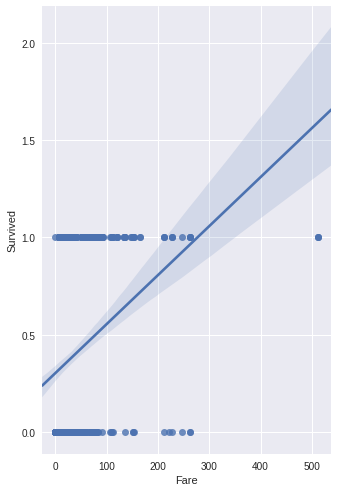

In [55]:
sns.pairplot(train_df, x_vars=['Fare'], y_vars='Survived', size=7, aspect=0.7, kind='reg')
plt.show()

So apart from high variance, it seems that the greater the Fare was, the more likely the passanger was to survive. 

Might it be heplful if we invert Survived and Fare axis? Let's use barplot now as we have only 2 values of X, since X now is Survived and not Fare:

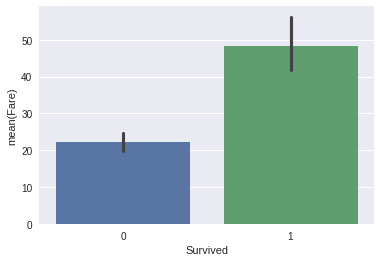

In [58]:
#sns.boxplot(train_df, x_vars=['Survived'], y_vars='Fare', size=7, aspect=0.7, kind='reg')
sns.barplot(x="Survived", y="Fare", data=train_df)
plt.show()

So the bulk of survivors paid a higher fare on average, eh? I'll assume it's correct for now.

### Cabin
Let's see if there were people in the same cabin:

In [4]:
train_df['Cabin'].value_counts().head()

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
C22 C26        3
Name: Cabin, dtype: int64

It seems that yes, there were cabins with several passengers, which may affect the probability of those passengers dying or to surviving together. So this means like a meaningful feature indeed, but what do I do with NaNs?...

### Ticket
Like with Cabin, there seem to be several people on some Tickets:

In [5]:
train_df['Ticket'].value_counts().head()

347082      7
1601        7
CA. 2343    7
347088      6
3101295     6
Name: Ticket, dtype: int64

Might this affect chances of those passengeers to survive, or not?

Anyway, if we want to use Ticket and Cabin features, we have to create "labels" for each Ticket type and Cabin type, and do something with those overwhelming NaNs in Cabin.

### Additional visualization
Let's try to see how various features might be related to passenger's survival.

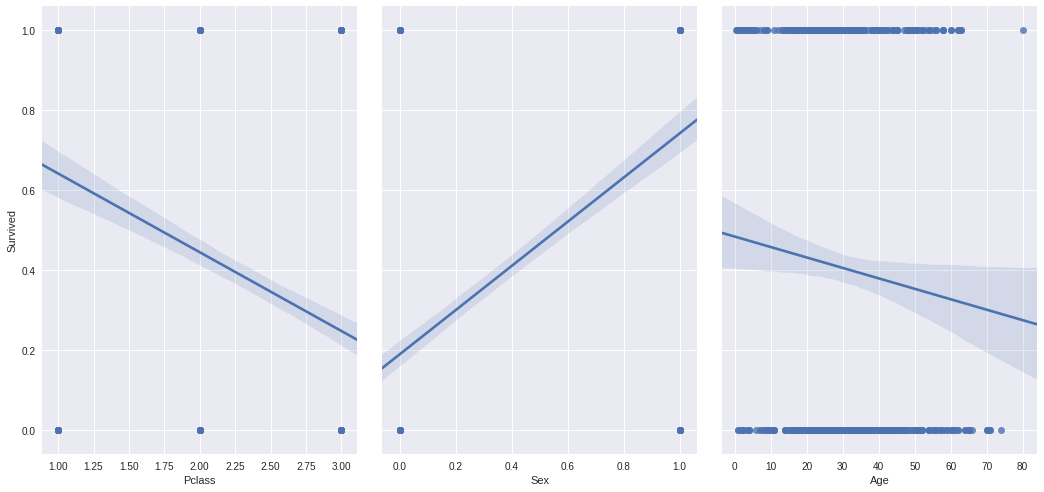

In [37]:
sns.pairplot(train_df, x_vars=['Pclass', 'Sex', 'Age'], y_vars='Survived', size=7, aspect=0.7, kind='reg')
plt.show()

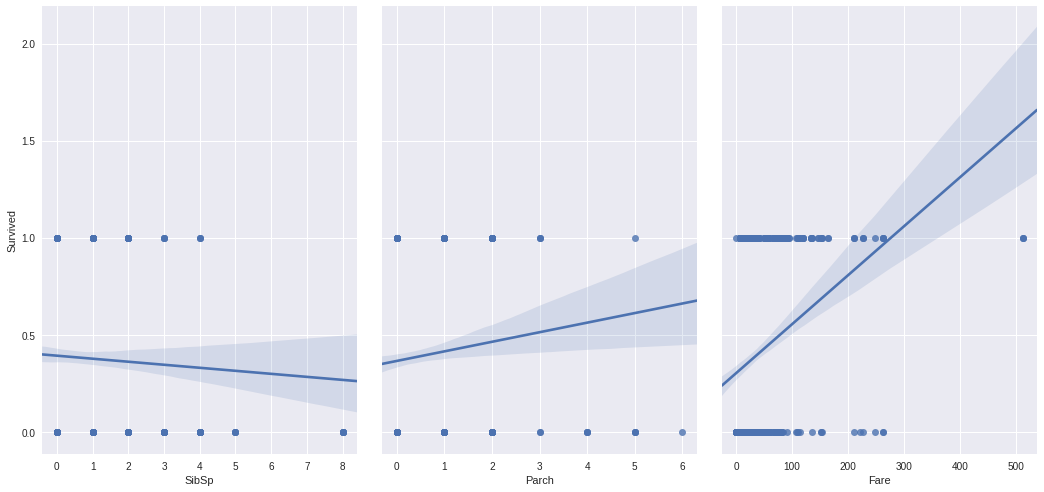

In [7]:
sns.pairplot(train_df, x_vars=['SibSp', 'Parch', 'Fare'], y_vars='Survived', size=7, aspect=0.7, kind='reg')
plt.show()

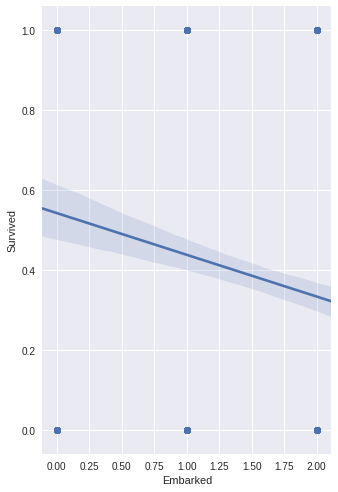

In [8]:
sns.pairplot(train_df, x_vars=['Embarked'], y_vars='Survived', size=7, aspect=0.7, kind='reg')
plt.show()